In [1]:
import os.path

import episcanpy as epi
import scanpy as sc
import numpy as np
import anndata as ad
import pandas as pd
from scipy.sparse import issparse, csr_matrix, hstack
import tempfile
import requests
import warnings

%load_ext autoreload
%autoreload 2

import utils

In [53]:
h5ad_path = "/mnt/workspace_stud/mbentse/catlas_objects/esophagus_muscularis_SM-A8CPH.h5ad"

data_folder = "/mnt/workspace_stud/allstud/wp1/data"
out_file = f"{data_folder}/multiple_cluster.h5ad"

metadata_url = "http://catlas.org/catlas_downloads/humantissues/Cell_metadata.tsv.gz"
metadata_filename = "Cell_metadata.tsv"
metadata_path = f"{data_folder}/catlas_metadata/{metadata_filename}"
ontology_path = f"{data_folder}/Cell_ontology.tsv"
ontology_url = "https://www.ebi.ac.uk/ols4/api/ontologies/cl/terms/http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F"

gtf_url="https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/gencode.v38.annotation.gtf.gz"
gtf_filename="gencode.v38.annotation.gtf"
gtf_path=f"{data_folder}/{gtf_filename}"

uropa_path = "/home/stud1/.conda/envs/datenanalyse/bin/uropa"
tmpdirobj = tempfile.TemporaryDirectory()
tmpdir = tmpdirobj.name
bed_path = f"{tmpdir}/esophagus_muscularis_SM-A8CPH.bed"
uropa_config = f"{tmpdir}/config.json"
uropa_output = f"{tmpdir}/esophagus_muscularis_SM-A8CPH_finalhits.txt"

In [3]:
adata = epi.read_h5ad(h5ad_path)

In [4]:
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, inplace=True)

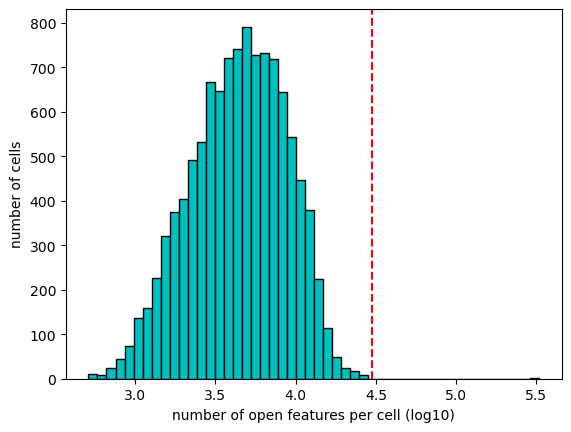

In [5]:
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=30000)

In [6]:
epi.pp.filter_cells(adata, min_features=100)
epi.pp.filter_cells(adata, max_features=30000)

In [7]:
utils.download(metadata_path, metadata_url)

/mnt/workspace_stud/allstud/wp1/data/catlas_metadata/Cell_metadata.tsv already exists.


In [8]:
utils.load_metadata(adata, metadata_path, columns_to_keep=['cell type'])

In [9]:
ontology_df = pd.read_csv(ontology_path, delimiter="\t")
ontology_df = ontology_df.rename(columns={
    "Cell type": "cell type", 
    "closest Cell Ontology term(s)": "ontology label",
    "Cell Ontology ID": "ontology id"})
adata.obs = pd.merge(adata.obs, ontology_df, how="left", on="cell type")

In [10]:
# 10% of all cells:
len(adata.obs["ontology label"])

10996

In [11]:
adata.obs["ontology label"].value_counts()

ontology label
fibroblast                              3201
smooth muscle cell of the esophagus     2686
macrophage                              1943
schwann cell                             579
CD8-positive, alpha-beta T cell          577
smooth muscle cell                       541
pericyte cell                            497
endothelial cell                         345
endothelial cell of lymphatic vessel     183
alveolar macrophage                      156
foveolar cell of stomach                 106
mast cell                                 86
mature NK T cell                          24
naive t cell                              16
cardiac endothelial cell                  10
stromal cell                              10
fibroblast of cardiac tissue               7
luteal cell                                6
enteric smooth muscle cell                 6
plasma cell                                5
CD4-positive, alpha-beta T cell            5
blood vessel smooth muscle cell         

In [12]:
# only keep labels that are bigger than 1% of cell count
threshold = len(adata.obs["ontology label"]) / 100.0
counts = adata.obs["ontology label"].value_counts()
valid_labels = counts[counts >= threshold].index
adata = adata[adata.obs["ontology label"].isin(valid_labels)].copy()
# TODO das Warning beheben ImplicitModificationWarning Transforming to str index.

In [13]:
adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,nb_features,cell type,ontology label,ontology id
16,2410,7.787797,3953.0,8.282483,2410,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
17,4710,8.457655,7891.0,8.973605,4710,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
18,2866,7.961021,4669.0,8.448915,2866,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
19,8464,9.043695,14382.0,9.573802,8464,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
20,8500,9.047939,14767.0,9.600218,8500,Smooth Muscle (Esophageal Muscularis) 1,smooth muscle cell of the esophagus,CL:0002599
...,...,...,...,...,...,...,...,...
10988,2470,7.812378,4080.0,8.314097,2470,Fibroblast (Gastrointestinal),fibroblast,CL:0000057
10989,2009,7.605890,3399.0,8.131531,2009,Fibroblast (Gastrointestinal),fibroblast,CL:0000057
10990,781,6.661855,1282.0,7.156956,781,Fibroblast (Gastrointestinal),fibroblast,CL:0000057
10991,1612,7.385851,2685.0,7.895808,1612,Fibroblast (Gastrointestinal),fibroblast,CL:0000057


In [14]:
utils.download(gtf_path, gtf_url)

/mnt/workspace_stud/allstud/wp1/data/gencode.v38.annotation.gtf already exists.


In [15]:
def parse_region(region):
    if ':' in region and '-' in region:
        chrom, positions = region.split(':')
        begin, end = map(int, positions.split('-'))
    elif '_' in region:
        chrom, begin, end = region.split('_')
        begin, end = int(begin), int(end)
    else:
        raise ValueError(f"Invalid region format: {region}")
    return chrom, begin, end

with open(bed_path, "w") as f:
    for region in adata.var_names.tolist():
        chrom, begin, end = parse_region(region)
        f.write(f"{chrom}\t{begin}\t{end}\n")
    f.flush()

In [16]:
%%bash -s {tmpdir} {uropa_config} {gtf_path} {bed_path}
cat >$2 << EOF
{
"queries":[
    {
        "distance": [5000, 2000],
        "feature": ["gene"],
        "feature_anchor": ["end", "start", "center"]
    }
],
"show_attributes": ["gene_name"],
"priority": "False",
"gtf": "$3",
"bed": "$4",
"outdir": "$1",
"threads": "$(nproc --all)"
}
EOF

In [17]:
%%time
!{uropa_path} -i {uropa_config}

2024-01-16 18:47:07 (783223) [INFO]	Started UROPA 4.0.3
2024-01-16 18:47:07 (783223) [INFO]	Working directory: /home/stud1/notebooks/release
2024-01-16 18:47:07 (783223) [INFO]	Command-line call: /home/stud1/.conda/envs/datenanalyse/bin/uropa -i /tmp/tmppv8ak4bz/config.json
2024-01-16 18:47:07 (783223) [INFO]	Reading configuration from commandline/input config
2024-01-16 18:47:07 (783223) [INFO]	Preparing .gtf-file for fast access
2024-01-16 18:47:43 (783223) [INFO]	Started annotation
2024-01-16 18:47:48 (783223) [INFO]	Progress: Annotated 35000 peaks (0 jobs running; 35 jobs finished)
2024-01-16 18:47:53 (783223) [INFO]	Progress: Annotated 85000 peaks (0 jobs running; 85 jobs finished)
2024-01-16 18:47:58 (783223) [INFO]	Progress: Annotated 135000 peaks (0 jobs running; 135 jobs finished)
2024-01-16 18:48:04 (783223) [INFO]	Progress: Annotated 185000 peaks (0 jobs running; 185 jobs finished)
2024-01-16 18:48:09 (783223) [INFO]	Progress: Annotated 235000 peaks (0 jobs running; 235 jobs

In [ ]:
uropa_df = pd.read_csv(uropa_output, delimiter="\t")
uropa_df['index'] = uropa_df['peak_chr'].astype(str) + ':' + uropa_df['peak_start'].astype(str) + '-' + uropa_df['peak_end'].astype(str)
uropa_df = uropa_df[['index', 'gene_name']]
uropa_df = uropa_df.set_index('index')
adata.var = adata.var.merge(uropa_df, left_index=True, right_index=True)

In [ ]:
tmpdirobj.cleanup()

In [ ]:
adata.var

In [ ]:
sc.pp.normalize_total(adata, exclude_highly_expressed=False, target_sum=None)
sc.pp.log1p(adata)

In [22]:
%%time
sc.pp.pca(adata, n_comps=16, use_highly_variable=False)

CPU times: user 1min 13s, sys: 2min 8s, total: 3min 22s
Wall time: 57.7 s


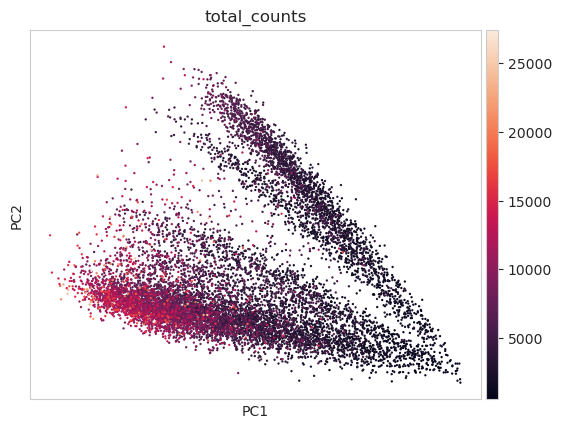

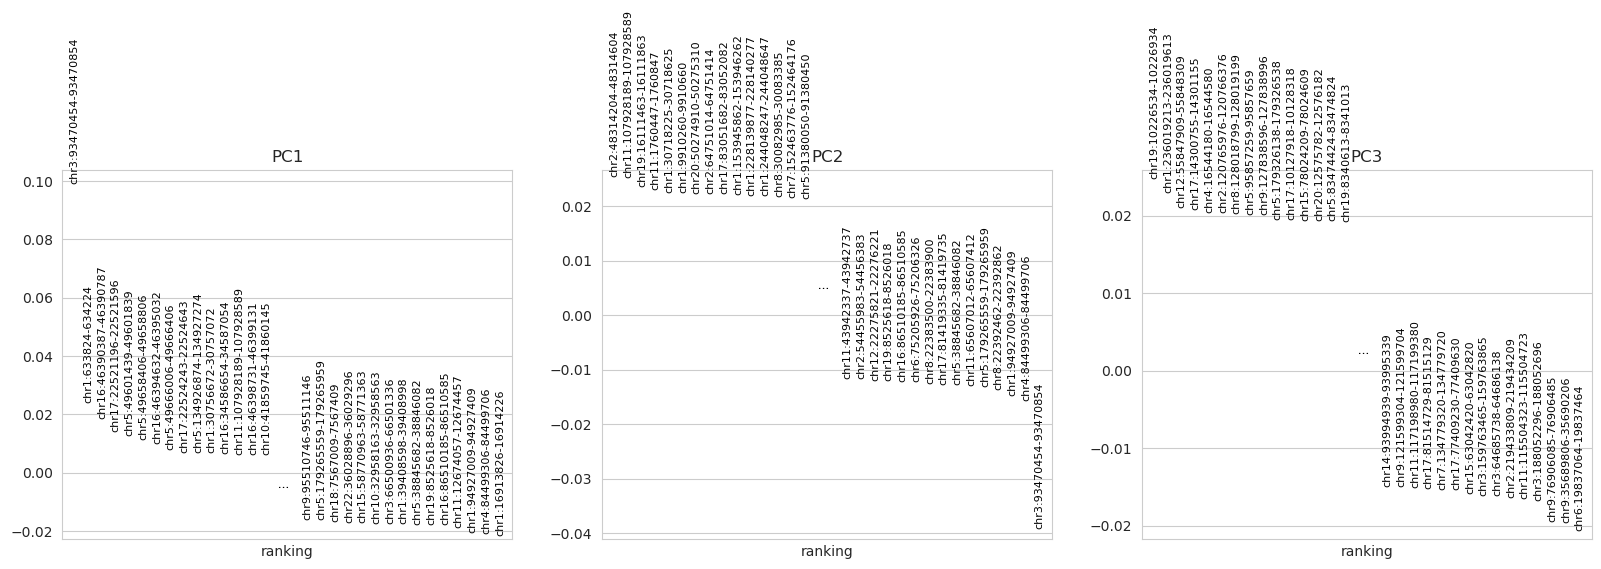

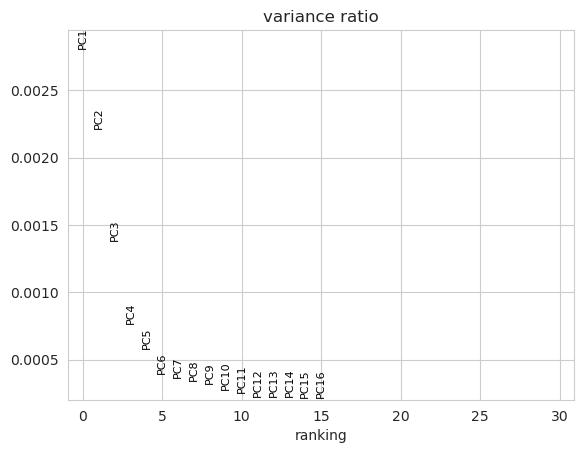

In [23]:
sc.pl.pca_overview(adata, color="total_counts")

In [24]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, method='umap', metric='euclidean')

CPU times: user 24.8 s, sys: 746 ms, total: 25.5 s
Wall time: 24.2 s


In [25]:
%%time
sc.tl.umap(adata, min_dist=0.1, spread=2.5)

CPU times: user 8.83 s, sys: 1.02 s, total: 9.85 s
Wall time: 8.47 s


<Axes: title={'center': 'log1p_n_genes_by_counts'}, xlabel='UMAP1', ylabel='UMAP2'>

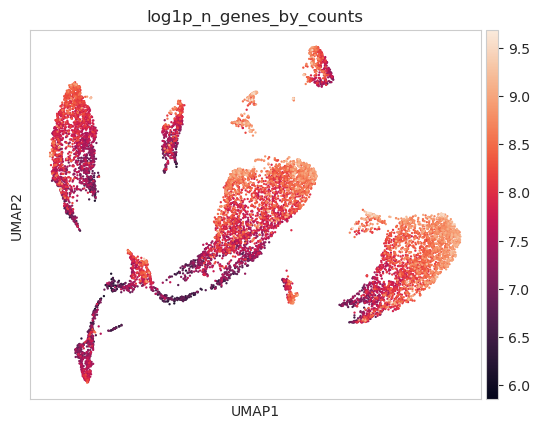

In [26]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="log1p_n_genes_by_counts")

In [32]:
%%time
if "clusters" not in adata.uns:
    adata.uns["clusters"] = dict()

params = [
    ["lovain", 0.1],
    ["lovain", 0.25],
    ["lovain", 0.5],
    ["lovain", 1],
    ["leiden", 0.1],
    ["leiden", 0.25],
    ["leiden", 0.5],
    ["leiden", 1],
    ["kmeans", 13],
    ["kmeans", 16]
]
for method, value in params:
    tag = f'{method}_{value}'
    
    if method == 'lovain':
        sc.tl.louvain(adata, resolution=value, key_added=tag)
    elif method == 'leiden':
        sc.tl.leiden(adata, resolution=value, key_added=tag)
    elif method == 'kmeans':
        epi.tl.kmeans(adata, num_clusters=value)
        adata.obs[tag] = adata.obs["kmeans"]
        del adata.obs["kmeans"]
    else:
        print("unknown method: {method}")
    # calculate scores
    ari = epi.tl.ARI(adata, tag, 'ontology label')
    ami = epi.tl.AMI(adata, tag, 'ontology label')
    print(f"Method: {method}")
    print(f"value: {value}")
    print(f"ARI: {ari}")
    print(f"AMI: {ami}")

    
    adata.uns["clusters"][tag] = {
        "method": method,
        "param": {
           "n_clusters" if method == "kmeans" else "resoltution": value 
        },
        "score": {
            "ari": ari,
            "ami": ami
        }
    }

Method: lovain
value: 0.1
ARI: 0.78625477699175
AMI: 0.7639391245332297
Method: lovain
value: 0.25
ARI: 0.8519995162881457
AMI: 0.8226903783316317
Method: lovain
value: 0.5
ARI: 0.7154916647160758
AMI: 0.7722828112036922
Method: lovain
value: 1
ARI: 0.4414366487530136
AMI: 0.6702955415206123
Method: leiden
value: 0.1
ARI: 0.8266163589360024
AMI: 0.8088883087715812
Method: leiden
value: 0.25
ARI: 0.8605349497368201
AMI: 0.8379952223041307
Method: leiden
value: 0.5
ARI: 0.6501698461839958
AMI: 0.7620431519517423
Method: leiden
value: 1
ARI: 0.44481831987399206
AMI: 0.6775912644910452


Method: kmeans
value: 13
ARI: 0.4346272873894663
AMI: 0.6306587369057126


Method: kmeans
value: 16
ARI: 0.41675966963475963
AMI: 0.6103092034765655
CPU times: user 18.4 s, sys: 6.84 s, total: 25.2 s
Wall time: 11.5 s


In [33]:
adata.uns["clusters"]

{'kmeans_16': {'method': 'kmeans',
  'param': {'n_clusters': 16},
  'score': {'ari': 0.41675966963475963, 'ami': 0.6103092034765655}},
 'lovain_0.1': {'method': 'lovain',
  'param': {'resoltution': 0.1},
  'score': {'ari': 0.78625477699175, 'ami': 0.7639391245332297}},
 'lovain_0.25': {'method': 'lovain',
  'param': {'resoltution': 0.25},
  'score': {'ari': 0.8519995162881457, 'ami': 0.8226903783316317}},
 'lovain_0.5': {'method': 'lovain',
  'param': {'resoltution': 0.5},
  'score': {'ari': 0.7154916647160758, 'ami': 0.7722828112036922}},
 'lovain_1': {'method': 'lovain',
  'param': {'resoltution': 1},
  'score': {'ari': 0.4414366487530136, 'ami': 0.6702955415206123}},
 'leiden_0.1': {'method': 'leiden',
  'param': {'resoltution': 0.1},
  'score': {'ari': 0.8266163589360024, 'ami': 0.8088883087715812}},
 'leiden_0.25': {'method': 'leiden',
  'param': {'resoltution': 0.25},
  'score': {'ari': 0.8605349497368201, 'ami': 0.8379952223041307}},
 'leiden_0.5': {'method': 'leiden',
  'param'

In [37]:
# calculate best cluster:
best_tag, best_ari = None, 0
for tag in adata.uns["clusters"]:
    ari = adata.uns["clusters"][tag]["score"]["ari"]
    if ari > best_ari:
        best_tag = tag
        best_ari = ari
print(best_tag, best_ari)
adata.uns["best_cluster"] = best_tag

leiden_0.25 0.8605349497368201


<Axes: title={'center': 'leiden_0.25'}, xlabel='UMAP1', ylabel='UMAP2'>

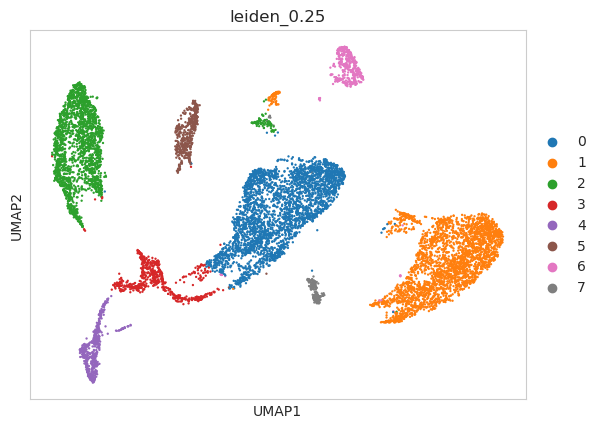

In [41]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color=adata.uns["best_cluster"])

<Axes: title={'center': 'ontology label'}, xlabel='UMAP1', ylabel='UMAP2'>

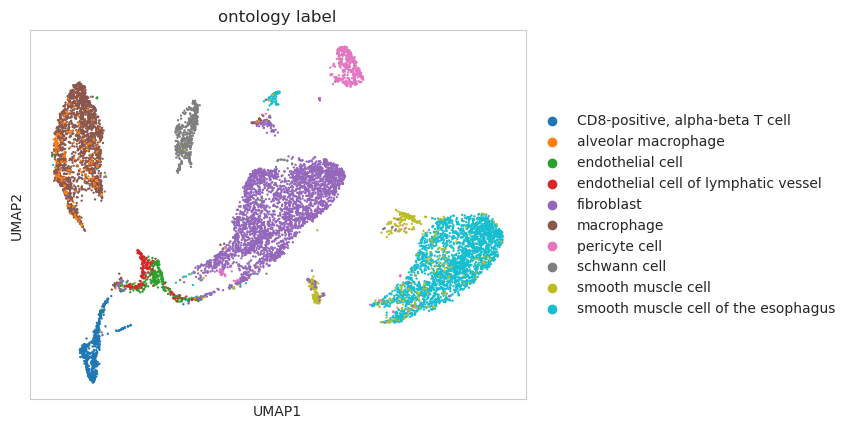

In [42]:
sc.pl.embedding(adata, basis='umap', ncols=3, show=False, color="ontology label")

__Rekey adata.var to genes__

In [43]:
# remove unannotated regions
adata = adata[:, ~adata.var['gene_name'].isna()]

In [44]:
duplicated_genes = adata.var['gene_name'][adata.var['gene_name'].duplicated(keep=False)]

In [45]:
%%time
adata_csc = adata.X.tocsc()

CPU times: user 1.01 s, sys: 139 ms, total: 1.14 s
Wall time: 1.14 s


In [46]:
%%time
merged_data_dict = {}
for gene in duplicated_genes.unique():
    cols = np.where(adata.var['gene_name'] == gene)[0]
    data_slice = adata_csc[:, cols]
    merged = data_slice.max(axis=1)
    merged_data_dict[gene] = merged

CPU times: user 38.3 s, sys: 287 ms, total: 38.6 s
Wall time: 38.6 s


In [47]:
%%time
non_duplicated_genes = adata.var['gene_name'][~adata.var['gene_name'].duplicated(keep=False)]
for gene in non_duplicated_genes:
    cols = np.where(adata.var['gene_name'] == gene)[0]
    data_slice = adata_csc[:, cols]
    merged_data_dict[gene] = data_slice

CPU times: user 2.81 s, sys: 29.8 ms, total: 2.84 s
Wall time: 2.84 s


In [48]:
merged_matrix = hstack([l for l in merged_data_dict.values()], format='csr')

In [49]:
adata_merged = ad.AnnData(X=merged_matrix, obs=adata.obs, obsm=adata.obsm, var=pd.DataFrame(index=merged_data_dict.keys()))

In [54]:
%%time
adata_merged.write(
        out_file,
        compression="gzip")

CPU times: user 4.17 s, sys: 41.8 ms, total: 4.21 s
Wall time: 4.24 s


In [51]:
adata_merged

AnnData object with n_obs × n_vars = 10708 × 52277
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'nb_features', 'cell type', 'ontology label', 'ontology id', 'lovain_0.1', 'lovain_0.25', 'lovain_0.5', 'lovain_1', 'leiden_0.1', 'leiden_0.25', 'leiden_0.5', 'leiden_1', 'kmeans_13', 'kmeans_16'
    obsm: 'X_pca', 'X_umap'